特征工程

In [1]:
#数据集和数据处理
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]  #显示中文
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split as TTS
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb



In [2]:
seed = 18

In [3]:
#导入数据
data = pd.read_csv('pima-indians-diabetes.csv')

In [4]:
#分离特征和标签
dataset = data.values
X = dataset[:,0:-1]
y = dataset[:,-1]

In [6]:
# 将数据拆分为训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3,
random_state=seed)

xgboost模型构建

In [7]:
#定义了一个二分类问题预测结果输出的函数，实现输出概率，评价指标：准确率、召回率、AUC、混淆矩阵、分类报告等结果信息。
def print_eval(Ypred,Ypredprob,Ytest,):
    '''
    :param Ypred：预测的分类结果
    :param Ypredprob：预测的分类概率
    :param Ytest：真实值
    :return: None
    '''
    print ("AUC: %.4f" % metrics.roc_auc_score(Ytest, Ypredprob))
    print ("Accuracy: %.4f" % metrics.accuracy_score(Ytest, Ypred))
    print ("Recall: %.4f" % metrics.recall_score(Ytest, Ypred))
    print ("F1-score: %.4f" %metrics.f1_score(Ytest, Ypred))
    print ("Precesion: %.4f" %metrics.precision_score(Ytest, Ypred))
    print("分类报告：\n",metrics.classification_report(Ytest, Ypred))
    confusion_matrix_result = metrics.confusion_matrix(Ytest, Ypred)
    print("混淆矩阵：\n",confusion_matrix_result)
    # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap="Blues",fmt=".0f")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()


In [8]:
#定义一个用于交叉验证的函数，该代码如下：
def modelfit( model, X_train, X_test, Y_train, Y_test, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50 ):
    '''
    :param model：xgboost模型
    :param X_train, X_test, Y_train, Y_test：训练集、测试集
    : param useTrainCV：是否使用cv函数
    :return: model：xgboost模型
    '''
    #若训练中使用交叉验证
    if useTrainCV:
        #获取模型参数
        xgb_param = model.get_xgb_params()
        num_boost=model.get_params()["n_estimators"]
        Dtrain = xgb.DMatrix(X_train, Y_train )
        cv_result  = xgb.cv(xgb_param, Dtrain, 
                          num_boost_round=num_boost, 
                          nfold=cv_folds,metrics="auc", 
                          early_stopping_rounds=early_stopping_rounds)
        model.set_params( n_estimators=cv_result .shape[0] )
    
    print( "n_estimators 最优值: %d" % cv_result .shape[0] )
    
    # 在训练集上训练model，评估指标为AUC
    model.fit( X_train, Y_train, eval_metric="auc" )
        
    # 根据训练好的模型，在训练数据上进行预测
    pred_train = model.predict( X_train )
    predprob_train = model.predict_proba( X_train )[:,1]
    
    # 根据训练好的模型，在测试数据上进行预测
    pred_test = model.predict( X_test )
    predprob_test = model.predict_proba( X_test )[:,1]    
    
    #输出预测的结果分析
    print("训练数据的结果分析：\n")
    print_eval(pred_train, predprob_train, Y_train)
    print("测试数据的结果分析：\n")
    print_eval(pred_test,predprob_test,Y_test)
    return model

AUC: 0.7579
Accuracy: 0.7359
Recall: 0.5679
F1-score: 0.6013
Precesion: 0.6389
分类报告：
               precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       150
         1.0       0.64      0.57      0.60        81

    accuracy                           0.74       231
   macro avg       0.71      0.70      0.70       231
weighted avg       0.73      0.74      0.73       231

混淆矩阵：
 [[124  26]
 [ 35  46]]


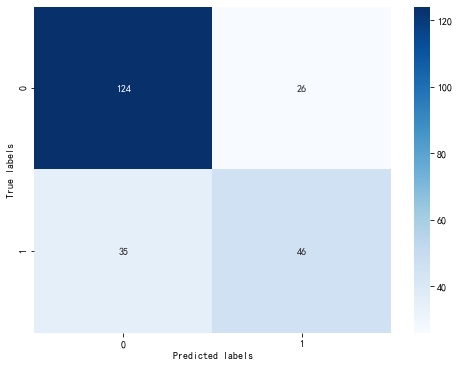

In [9]:
#设seed为统一值
seed=18 
#设计模型参数
xgb_params_sklearn = {
    "n_estimators": 1000, #基础模型的数量
    "booster": "gbtree",  #基础模型的类型
    "objective": "binary:logistic",#二分类问题
    "seed": seed,         #随机种子
    "learning_rate": 0.1, #学习率 
    "gamma": 0.1,         # 用于控制是否后剪枝的参数,越大越保守
    "colsample_bytree": 0.8,# 生成模型时进行的列采样 
    "subsample": 0.8,       # 随机采样训练样本 
    "max_depth": 5,         # 构建模型的深度，越大越容易过拟合
    "min_child_weight": 1,  #最小叶子节点样本权重之和
    "eval_metric": "auc",   #模型训练的损失函数为AUC
    "nthread": 4,           # CPU线程数 
}

#训练模型
bst_sklearn=XGBClassifier(**xgb_params_sklearn,use_label_encoder=False)
bst_sklearn.fit(Xtrain, Ytrain,eval_metric="auc")
#预测数据
Y_pred = bst_sklearn.predict(Xtest)
Y_predprob = bst_sklearn.predict_proba(Xtest)[:,1]
print_eval( Y_pred,Y_predprob,Ytest)


调参基本上包括以下四步：
Step1：确定“最优树的个数”。
Step2：根据确定的学习率和树的个数，调整“树相关的参数”，比如max_depth, min_child_weight, gamma, subsample, colsample_bytree。
Step3：为避免过拟合，调“正则化参数”，如lambda, alpha。
Step4：用之前调好的参数，减小学习率并增大树个数，确定模型。


n_estimators 最优值: 44
训练数据的结果分析：

AUC: 0.9838
Accuracy: 0.9385
Recall: 0.8877
F1-score: 0.9096
Precesion: 0.9326
分类报告：
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       350
         1.0       0.93      0.89      0.91       187

    accuracy                           0.94       537
   macro avg       0.94      0.93      0.93       537
weighted avg       0.94      0.94      0.94       537

混淆矩阵：
 [[338  12]
 [ 21 166]]


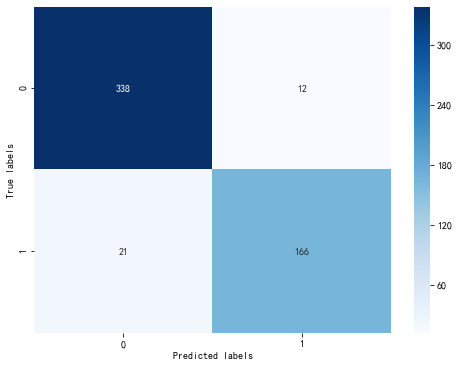

测试数据的结果分析：

AUC: 0.7837
Accuracy: 0.7273
Recall: 0.4938
F1-score: 0.5594
Precesion: 0.6452
分类报告：
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       150
         1.0       0.65      0.49      0.56        81

    accuracy                           0.73       231
   macro avg       0.70      0.67      0.68       231
weighted avg       0.72      0.73      0.72       231

混淆矩阵：
 [[128  22]
 [ 41  40]]


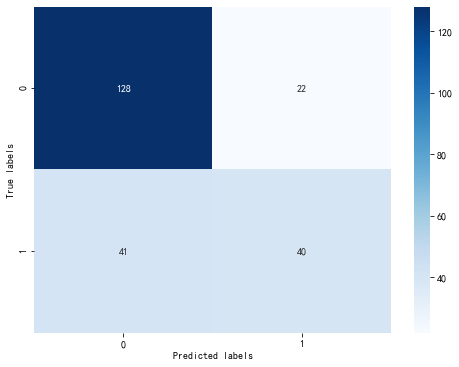

In [10]:
#Step1：开始用一个业界公认的学习率0.1，然后根据交叉验证误差作为评估指标，确定基准模型数量。代码如下：
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)


In [11]:
#（1）使用上一步得到的模型bst_sklearn（树的个数为363），因为参数max_depth和min__child_weight对最终结果有很大的影响，所以先对他们进行数调优。
#设置max_depth和min_child_weight的取值
xgb_param_grid1 = {
 "max_depth":range(3,10,2),
 "min_child_weight":range(1,6,2)
}
#GridSearchCV寻优max_depth和min_child_weight
gsearch1 = GridSearchCV(estimator =bst_sklearn,
                        param_grid=xgb_param_grid1,
                        scoring="roc_auc",n_jobs=4,cv=5)

gsearch1.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch1.best_params_)



最佳模型参数grid.best_params_  {'max_depth': 3, 'min_child_weight': 5}


In [12]:
#微调max_depth和min_child_weight，让其分别在3和5的基础上浮动1，代码如下：
#获得gsearch1.best_estimator_
bst_sklearn=gsearch1.best_estimator_
#微调并设置max_depth和min_child_weight的取值
xgb_param_grid1 = {
 "max_depth":[2,3,4],
 "min_child_weight":[4,5,6]
}
#GridSearchCV寻优max_depth和min_child_weight
gsearch1 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid1,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch1.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch1.best_params_)



最佳模型参数grid.best_params_  {'max_depth': 3, 'min_child_weight': 6}


In [13]:
#（2）在获得的模型gsearch1.best_estimator_基础上对gamma参数调优，
#获得gsearch1.best_estimator_
bst_sklearn=gsearch1.best_estimator_
xgb_param_grid2 = {"gamma":[ 0.1 * i for i in range(0,5)]}
#GridSearchCV寻优gamma
gsearch2 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid2,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch2.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch2.best_params_)




最佳模型参数grid.best_params_  {'gamma': 0.2}


n_estimators 最优值: 44
训练数据的结果分析：

AUC: 0.9194
Accuracy: 0.8324
Recall: 0.7219
F1-score: 0.7500
Precesion: 0.7803
分类报告：
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       350
         1.0       0.78      0.72      0.75       187

    accuracy                           0.83       537
   macro avg       0.82      0.81      0.81       537
weighted avg       0.83      0.83      0.83       537

混淆矩阵：
 [[312  38]
 [ 52 135]]


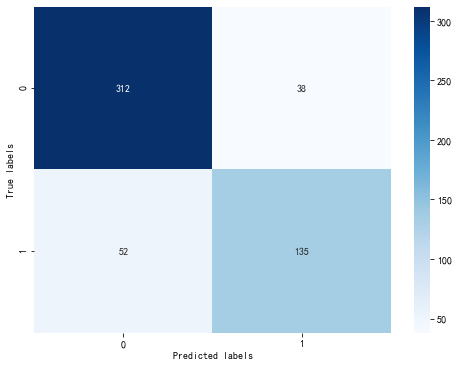

测试数据的结果分析：

AUC: 0.7868
Accuracy: 0.7359
Recall: 0.5062
F1-score: 0.5734
Precesion: 0.6613
分类报告：
               precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       150
         1.0       0.66      0.51      0.57        81

    accuracy                           0.74       231
   macro avg       0.71      0.68      0.69       231
weighted avg       0.73      0.74      0.73       231

混淆矩阵：
 [[129  21]
 [ 40  41]]


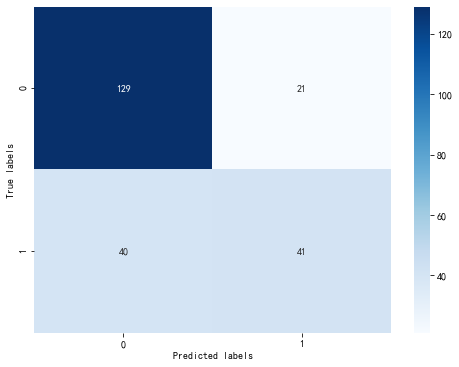

In [14]:
#获得gsearch2.best_estimator_
bst_sklearn=gsearch2.best_estimator_
#训练模型，返回最优树的个数
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest )


In [15]:
#采用类似的方法，调整subsample和colsample_bytree
#设置subsample和colsample_bytree的取值
xgb_param_grid3 = {
 "subsample":[i/10.0 for i in range(6,10)],
 "colsample_bytree":[i/10.0 for i in range(6,10)]
}
#GridSearchCV寻优subsample和colsample_bytree
gsearch3 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid3,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch3.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch3.best_params_)



最佳模型参数grid.best_params_  {'colsample_bytree': 0.8, 'subsample': 0.8}


In [16]:
#Step3：调“正则化参数”，如reg_alpha，再确定最优n_estimators。
#设置reg_alpha的取值
bst_sklearn=gsearch3.best_estimator_
xgb_param_grid4 = { "reg_alpha":[ 0.5, 1, 5, 10]}
#GridSearchCV寻优reg_alpha
gsearch4 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid4,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch4.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch4.best_params_)



最佳模型参数grid.best_params_  {'reg_alpha': 0.5}


n_estimators 最优值: 44
训练数据的结果分析：

AUC: 0.9156
Accuracy: 0.8399
Recall: 0.7273
F1-score: 0.7598
Precesion: 0.7953
分类报告：
               precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       350
         1.0       0.80      0.73      0.76       187

    accuracy                           0.84       537
   macro avg       0.83      0.81      0.82       537
weighted avg       0.84      0.84      0.84       537

混淆矩阵：
 [[315  35]
 [ 51 136]]


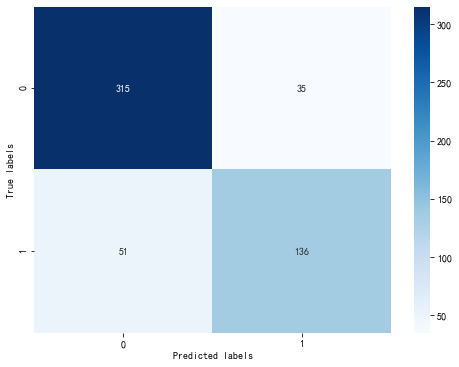

测试数据的结果分析：

AUC: 0.7835
Accuracy: 0.7273
Recall: 0.5062
F1-score: 0.5655
Precesion: 0.6406
分类报告：
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       150
         1.0       0.64      0.51      0.57        81

    accuracy                           0.73       231
   macro avg       0.70      0.68      0.68       231
weighted avg       0.72      0.73      0.72       231

混淆矩阵：
 [[127  23]
 [ 40  41]]


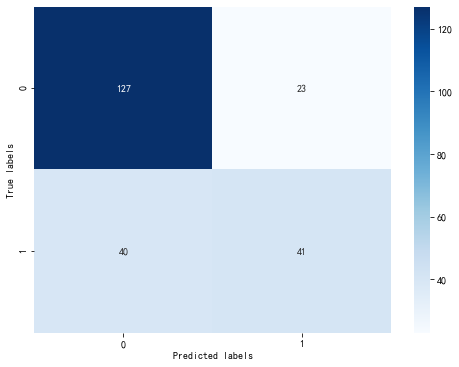

In [17]:
bst_sklearn=gsearch4.best_estimator_
#训练模型，返回最优树的个数
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)


n_estimators 最优值: 320
训练数据的结果分析：

AUC: 0.9087
Accuracy: 0.8231
Recall: 0.6898
F1-score: 0.7309
Precesion: 0.7771
分类报告：
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.87       350
         1.0       0.78      0.69      0.73       187

    accuracy                           0.82       537
   macro avg       0.81      0.79      0.80       537
weighted avg       0.82      0.82      0.82       537

混淆矩阵：
 [[313  37]
 [ 58 129]]


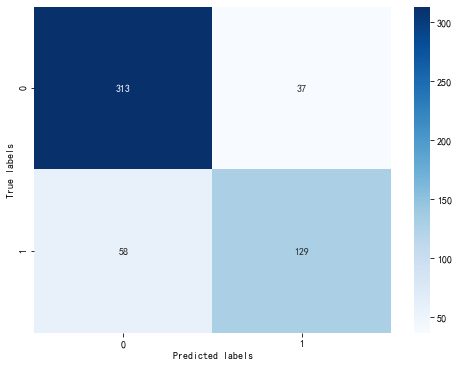

测试数据的结果分析：

AUC: 0.7881
Accuracy: 0.7273
Recall: 0.4938
F1-score: 0.5594
Precesion: 0.6452
分类报告：
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       150
         1.0       0.65      0.49      0.56        81

    accuracy                           0.73       231
   macro avg       0.70      0.67      0.68       231
weighted avg       0.72      0.73      0.72       231

混淆矩阵：
 [[128  22]
 [ 41  40]]


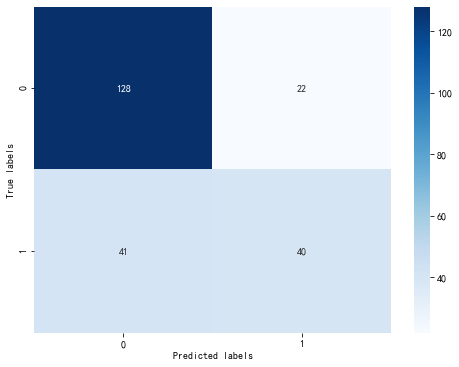

In [18]:
#Step4：用调好的参数，使用更小的学习率并增大n_estimaors，训练模型并评估，代码如下：
#获得gsearch4.best_estimator_
bst_sklearn=gsearch4.best_estimator_
bst_sklearn.set_params(n_estimators=2000,learning_rate=0.01)
#训练模型并评估
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)
